## Music League Stats

All of the data is scraped into a pandas dataframe with each row 

In [1]:
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm


from scraper import translator, create_dataframe
from spotify_data import get_spotify_data, get_playlist, playlists

In [2]:
path = Path("../music_league/")

df, names = create_dataframe(path=path, translator=translator)
df = get_spotify_data(music_league_df=df)

In [3]:
round_names = (
    "generation game",
    "remix",
    "songs to code to",
    "ich spreche kein englisch",
    "wish you were here",
    "film soundtrack",
    "yesteryear",
    "120 seconds to go",
    "cover",
    "eurovision"
)

## Voting Matrix

In [4]:
winning_order = df.groupby(df["submitter"])[names].sum().sum(axis=1)
winning_order = winning_order.sort_values(ascending=False).index


arr = np.concatenate([
        group.reindex(winning_order, fill_value=0.0).to_numpy()[None, :, :]
        for _, group in df.set_index(df["submitter"]).groupby("round")[winning_order]], axis=0)
correlation = np.sum(arr, axis=0)

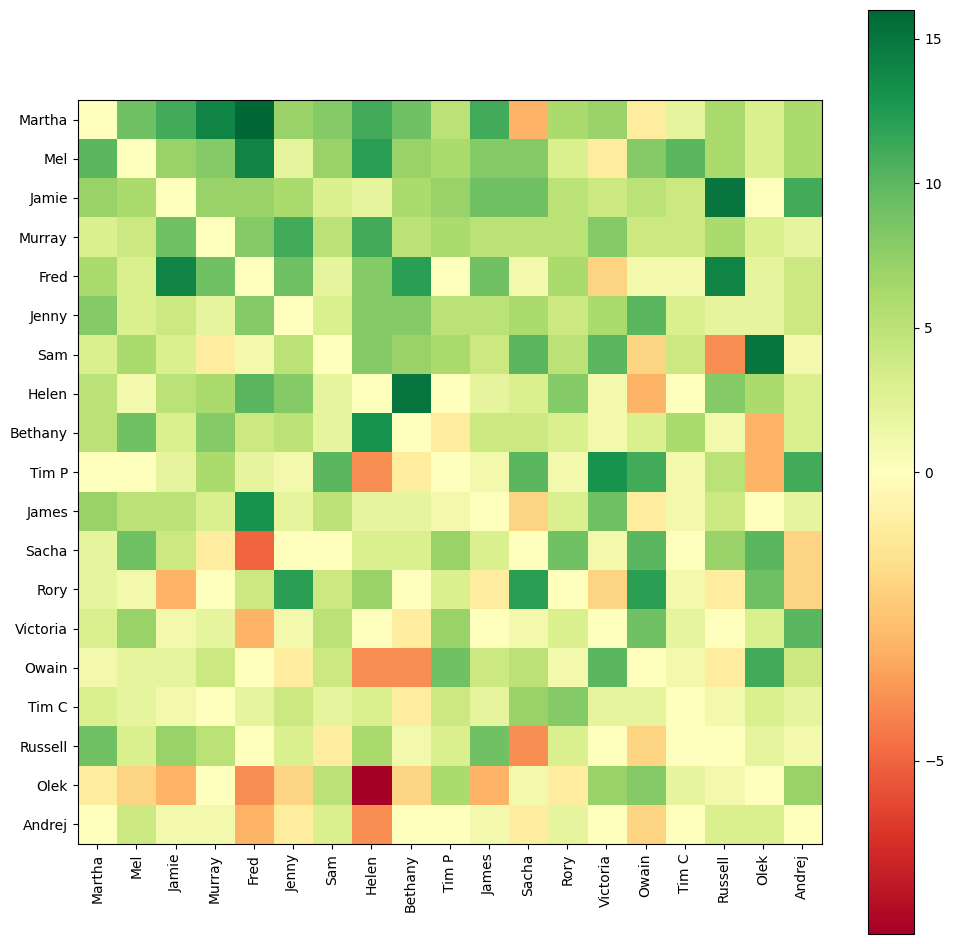

In [5]:
fig, ax = plt.subplots(figsize=(12,12))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
norm = TwoSlopeNorm(vmin=np.min(correlation),
                        vcenter=0,
                        vmax=np.max(correlation))

plt.imshow(correlation, cmap='RdYlGn', norm=norm, interpolation='nearest')
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')
plt.yticks(np.arange(len(winning_order)), winning_order)


cbar = plt.colorbar()

plt.show()

In [6]:
biggest_stans = np.unravel_index(np.argsort(-correlation.reshape(-1))[:10], correlation.shape)
for row, col in zip(*biggest_stans):
    print(f"{winning_order[col]} for {winning_order[row]}: {correlation[row, col]}")


Fred for Martha: 16.0
Bethany for Helen: 15.0
Russell for Jamie: 15.0
Olek for Sam: 15.0
Jamie for Fred: 14.0
Russell for Fred: 14.0
Fred for Mel: 14.0
Murray for Martha: 14.0
Victoria for Tim P: 13.0
Fred for James: 13.0


In [7]:
biggest_haters = np.unravel_index(np.argsort(correlation.reshape(-1))[:10], correlation.shape)
for row, col in zip(*biggest_haters):
    print(f"{winning_order[col]} for {winning_order[row]}: {correlation[row, col]}")


Helen for Olek: -8.0
Fred for Sacha: -5.0
Russell for Sam: -4.0
Fred for Olek: -4.0
Sacha for Russell: -4.0
Bethany for Owain: -4.0
Helen for Andrej: -4.0
Helen for Tim P: -4.0
Helen for Owain: -4.0
Fred for Victoria: -3.0


In [8]:
df["round_score"] = df[winning_order].sum(axis=1)

# Round winners

for round_name, (round, scores) in zip(round_names, df.groupby("round")):
    winning_score = scores["round_score"].max()
    a = f"Round {round} | {round_name}"
    print(a + "\n" + '-'*len(a))
    for _, row in scores[scores["round_score"] == winning_score][["submitter", "track_name", "round_score"]].iterrows():
        print(f"{row['submitter']:10} | {row['track_name']:40} | {int(row['round_score'])}")
    print()


Round 1 | generation game
-------------------------
Sacha      | Message In A Bottle                      | 16
Bethany    | Gypsy Woman (La Da Dee La Da Da)         | 16

Round 2 | remix
---------------
Murray     | 19-2000 - Soulchild Remix                | 19
Martha     | Flowers - Sunship Remix                  | 19

Round 3 | songs to code to
--------------------------
Jenny      | Song of Storms                           | 18

Round 4 | ich spreche kein englisch
-----------------------------------
Murray     | Mundian to Bach Ke                       | 29

Round 5 | wish you were here
----------------------------
Mel        | London Calling - Remastered              | 19

Round 6 | film soundtrack
-------------------------
Jamie      | Lose Yourself                            | 23

Round 7 | yesteryear
--------------------
Jamie      | Nothing Matters                          | 15

Round 8 | 120 seconds to go
---------------------------
Mel        | Fell In Love With a Girl       

In [9]:
df.sort_values("round_score", ascending=False).iloc[:10][["submitter", "track_name", "round_score"]]

,submitter,track_name,round_score
168,Murray,Mundian to Bach Ke,29.0
76,Jamie,Lose Yourself,23.0
57,Jamie,Hurt,23.0
38,Mel,Fell In Love With a Girl,21.0
77,Martha,9 to 5,21.0
0,Rory,SHUM,20.0
151,Martha,Flowers - Sunship Remix,19.0
131,Mel,London Calling - Remastered,19.0
150,Murray,19-2000 - Soulchild Remix,19.0
113,Jenny,Song of Storms,18.0


In [10]:
df.sort_values("round_score", ascending=True).iloc[:10][["submitter", "track_name", "round_score"]]

,submitter,track_name,round_score
56,Andrej,Baby Shark,-17.0
93,Olek,Waters of Nazareth x We Are your Friends x Pha...,-13.0
75,James,Bohemian Rhapsody,-11.0
18,Russell,Congratulations,-10.0
186,Andrej,Dragostea Din Tei,-10.0
74,Sacha,Painkiller,-7.0
148,Bethany,Atlantic City,-5.0
185,Tim P,Tequila,-5.0
130,Olek,Final - Live Version - Rappel,-5.0
92,Andrej,"Come What May - From ""Moulin Rouge"" Soundtrack",-5.0


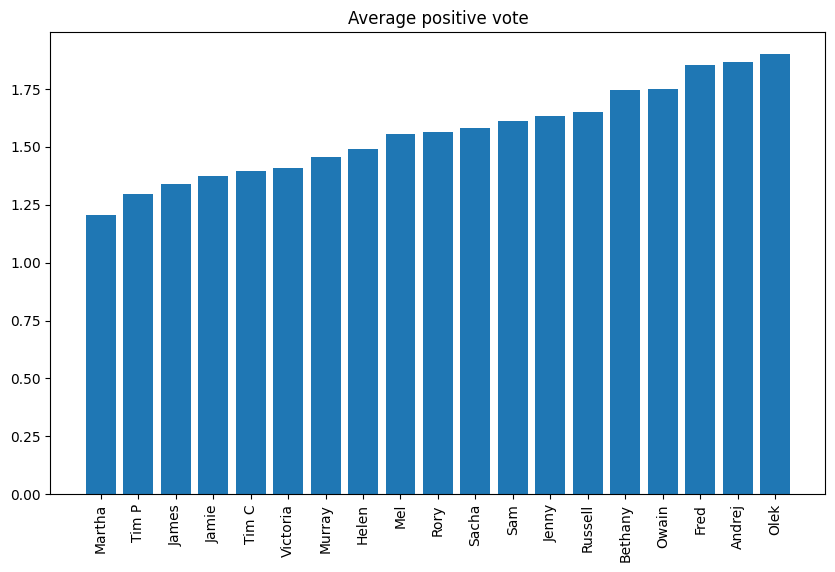

In [11]:
x = arr.reshape(-1, len(winning_order))
x[x <= 0.0] = np.nan
a = np.nanmean(x, axis=0)

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Average positive vote")

ax.bar(np.arange(len(winning_order)), a[np.argsort(a)])
ax.set_xticks(np.arange(len(winning_order)), labels=[winning_order[i] for i in np.argsort(a)], rotation="vertical")

plt.show()

In [12]:
df["song_age_seconds"] = (datetime.now() - df["date"]).dt.total_seconds()

In [13]:
# Average song age

df.groupby("submitter")["song_age_seconds"].mean().sort_values().map(lambda x: datetime.now() - timedelta(seconds=x))

submitter
Victoria   2017-06-01 12:00:00.015123
Rory       2016-05-26 07:12:00.015145
Owain      2015-03-18 14:24:00.015146
Olek       2013-07-03 00:00:00.015147
Sam        2012-07-15 04:48:00.015148
Murray     2012-03-01 07:12:00.015149
Andrej     2010-06-12 00:00:00.015150
Tim P      2007-01-22 12:00:00.015151
Jenny      2006-05-20 00:00:00.015152
Helen      2006-05-14 16:48:00.015153
Bethany    2006-04-13 16:00:00.015154
Tim C      2005-04-27 15:00:00.015156
Mel        2004-10-30 09:36:00.015157
Sacha      2002-02-24 16:48:00.015158
Martha     2001-09-21 16:48:00.015159
Jamie      2001-07-10 07:12:00.015161
Russell    2000-02-20 07:12:00.015162
James      1998-11-06 14:24:00.015163
Fred       1993-08-02 02:24:00.015165
Name: song_age_seconds, dtype: datetime64[ns]

In [14]:
# song length

df[df["round"] != 8].groupby("submitter")["duration"].sum()

submitter
Andrej      1848.219
Bethany     1723.012
Fred        2146.785
Helen       2266.625
James       2915.843
Jamie       2389.655
Jenny       1890.889
Martha      2137.663
Mel         1868.776
Murray      2037.116
Olek        2260.932
Owain       1887.041
Rory        2030.768
Russell     2825.664
Sacha       2442.544
Sam         1832.054
Tim C       1694.391
Tim P       1813.080
Victoria    1775.183
Name: duration, dtype: float64

In [15]:
df.sort_values("duration", ascending=False)[["submitter", "track_name", "duration"]].iloc[:10]

,submitter,track_name,duration
125,Russell,Blue Room,1053.813
127,James,Never Gonna Reach Me - Hot Toddy Remix,580.363
118,Sacha,Exercises in Futility V,495.626
160,Jamie,"Girls & Boys - Pet Shop Boys Remix, 2012 Remaster",436.546
37,Tim C,Seek & Destroy - Remastered,414.720
157,James,"Relight My Fire - 12"" Disco Remix",406.213
93,Olek,Waters of Nazareth x We Are your Friends x Pha...,391.782
154,Helen,Heads Will Roll - A-Trak Remix,383.893
65,Murray,War Pigs,379.647
100,James,Satisfy My Soul,362.956


In [16]:
df[df["round"]!=8].sort_values("duration")[["submitter", "track_name", "duration"]].iloc[:10]

,submitter,track_name,duration
129,Victoria,Baby Park,55.500
15,Sam,Bono's a Fucking Cunt,95.506
182,Sacha,Policia - 2017 Remaster,106.866
95,Bethany,Speed Drive (From Barbie The Album),117.809
178,Bethany,Laisse Tomber Les Filles,125.933
124,Sam,Screaming Man - Sound Effect,133.355
185,Tim P,Tequila,135.240
183,Tim C,Die Eier von Satan,137.360
96,Andrej,My Love Mine All Mine,137.773
87,Owain,"Comptine d'un autre été, l'après-midi",140.733


In [17]:
# Energy

df.groupby("submitter")["energy"].mean().sort_values(ascending=False)

submitter
Sacha       0.893900
Rory        0.863600
Murray      0.788190
Mel         0.768800
Sam         0.767300
Tim C       0.765429
Jenny       0.758900
Helen       0.748000
Tim P       0.738600
Bethany     0.736333
Owain       0.732200
Russell     0.719800
Jamie       0.692300
Victoria    0.692000
James       0.661500
Olek        0.656600
Fred        0.626700
Martha      0.619100
Andrej      0.509002
Name: energy, dtype: float64

In [18]:
df.sort_values("energy", ascending=False)[["submitter", "track_name", "energy"]].iloc[:10]

,submitter,track_name,energy
130,Olek,Final - Live Version - Rappel,0.996
74,Sacha,Painkiller,0.995
31,Rory,(sic),0.994
182,Sacha,Policia - 2017 Remaster,0.991
42,Sam,Freaks to the Front,0.988
129,Victoria,Baby Park,0.982
38,Mel,Fell In Love With a Girl,0.982
159,Sacha,Jesus Built My Hotrod (Powerman 5000 Remix),0.979
36,Owain,輪舞-revolution,0.975
118,Sacha,Exercises in Futility V,0.971


In [19]:
df.sort_values("energy")[["submitter", "track_name", "energy"]].iloc[:10]

,submitter,track_name,energy
126,Andrej,4'33'',0.00002
85,Murray,Concerning Hobbits,0.06290
71,Olek,Creep,0.10800
39,Jamie,Golden Slumbers - Remastered 2009,0.15200
124,Sam,Screaming Man - Sound Effect,0.18200
87,Owain,"Comptine d'un autre été, l'après-midi",0.19200
117,Tim P,Vision On,0.19400
52,Fred,Cripple Creek Ferry,0.22200
24,Andrej,Dub Be Good To Me,0.27200
58,Bethany,Killing Me Softly With His Song,0.28900


In [20]:
df.sort_values("danceability", ascending=False)[["submitter", "track_name", "danceability"]].iloc[:10]

,submitter,track_name,danceability
121,Martha,Computer World - 2009 Remaster,0.931
51,Helen,BIZCOCHITO,0.930
28,Mel,Family Affair,0.911
41,Jenny,Old Town Road,0.907
32,Murray,Me Myself and I,0.889
2,Martha,Think About Things,0.872
24,Andrej,Dub Be Good To Me,0.861
30,Helen,Can I Kick It?,0.848
50,Olek,Fly Away,0.846
56,Andrej,Baby Shark,0.829


In [21]:
df.sort_values("danceability")[["submitter", "track_name", "danceability"]].iloc[:10]

,submitter,track_name,danceability
126,Andrej,4'33'',0.173
149,Tim C,Munich,0.184
35,Russell,New Rose,0.191
118,Sacha,Exercises in Futility V,0.194
71,Olek,Creep,0.200
136,Martha,By The Time I Get To Phoenix - Remastered 2001,0.218
146,Jamie,Trains To Brazil,0.256
65,Murray,War Pigs,0.275
92,Andrej,"Come What May - From ""Moulin Rouge"" Soundtrack",0.288
15,Sam,Bono's a Fucking Cunt,0.304


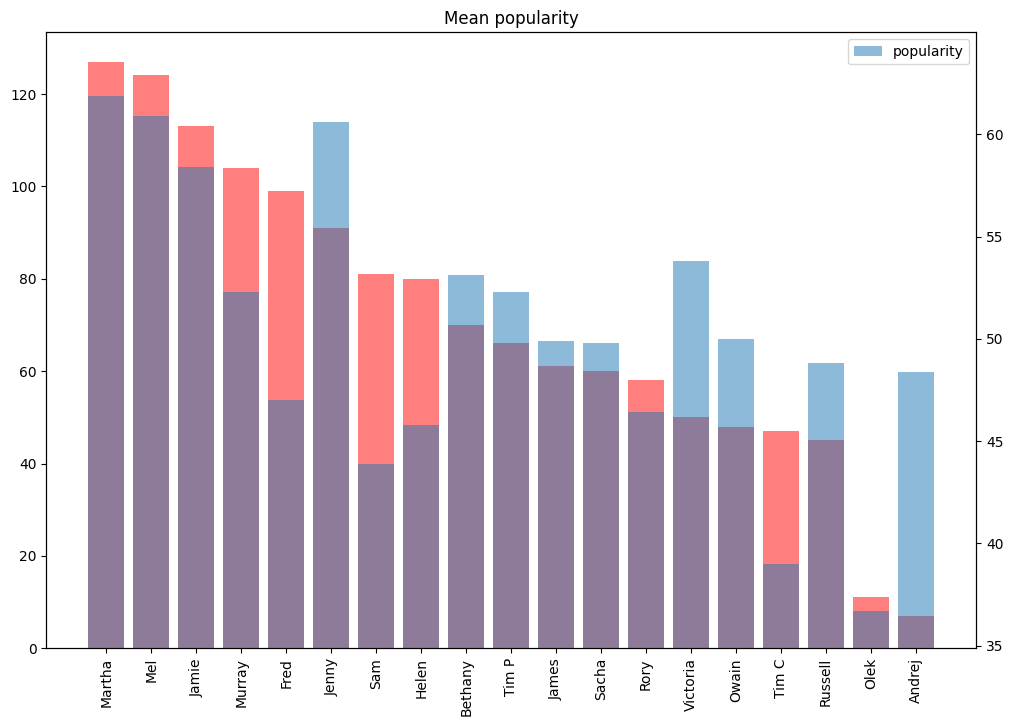

In [50]:
# popularity

fig, ax = plt.subplots(figsize=(12, 8))

total_score = actual = df.groupby("submitter")[winning_order].sum().sum(axis=1).reindex(winning_order)
ax.bar(range(len(total_score)), total_score, alpha=0.5, color="red")
ax.set_xticks(range(len(winning_order)), winning_order, rotation="vertical", label="actual score")

ax2 = ax.twinx()

pop = df.groupby("submitter")["popularity"].mean().reindex(winning_order)
ax2.bar(range(len(pop)), pop, alpha=0.5, label="popularity")
ax2.set_ylim(min(pop)*0.95, max(pop)*1.05)


ax.set_title("Mean popularity")

plt.legend()

plt.show()

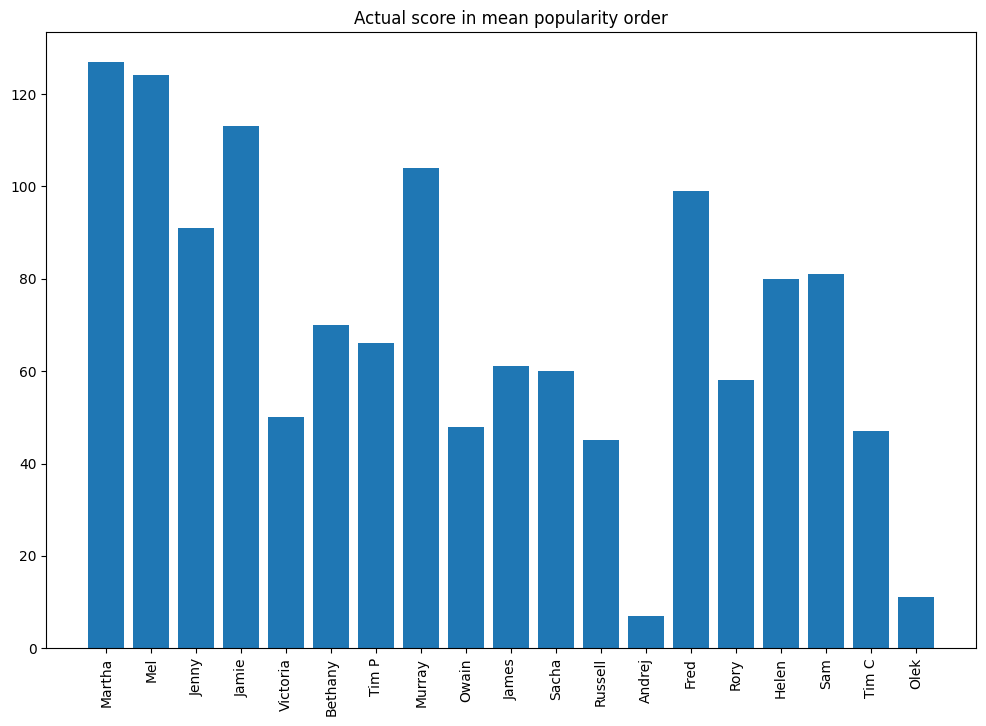

In [23]:
actual = df.groupby("submitter")[winning_order].sum().sum(axis=1).reindex(pop.index)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(range(len(pop)), actual)
ax.set_xticks(range(len(pop)), pop.index, rotation="vertical")


ax.set_title("Actual score in mean popularity order")

plt.show()

In [24]:
playlists = [get_playlist(playlist) for playlist in playlists]

In [25]:
i, a = list(df.groupby("round"))[0]

vals = []

for i, a in df.groupby("round"):
    vals.append(a.sort_values("round_score", ascending=False)["song_id"].map(lambda x: playlists[i-1].index(x)))

vals[0]

19     6
20     1
21     4
22     2
23    11
24     9
25    13
26     7
28    10
27    17
29    18
30    14
31     3
32     5
33    16
34    15
35    12
36     0
37     8
Name: song_id, dtype: int64

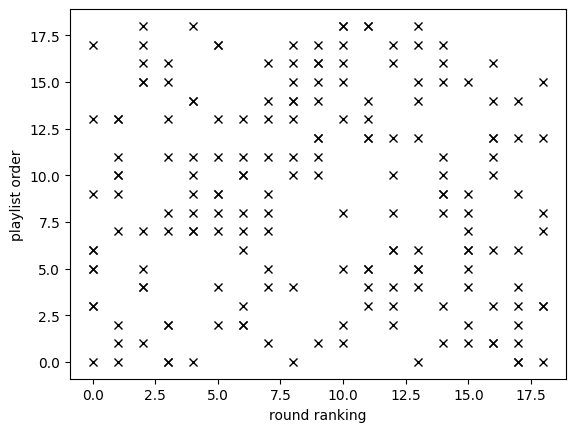

In [26]:
rankings = np.array([i for df in vals for i in range(len(df))])
playlist_order = np.array([i for df in vals for i in df.values])

plt.xlabel("round ranking")
plt.ylabel("playlist order")

plt.plot(rankings, playlist_order, "kx")
plt.show()


In [27]:
np.corrcoef(rankings, playlist_order)

array([[ 1.        , -0.04435978],
       [-0.04435978,  1.        ]])

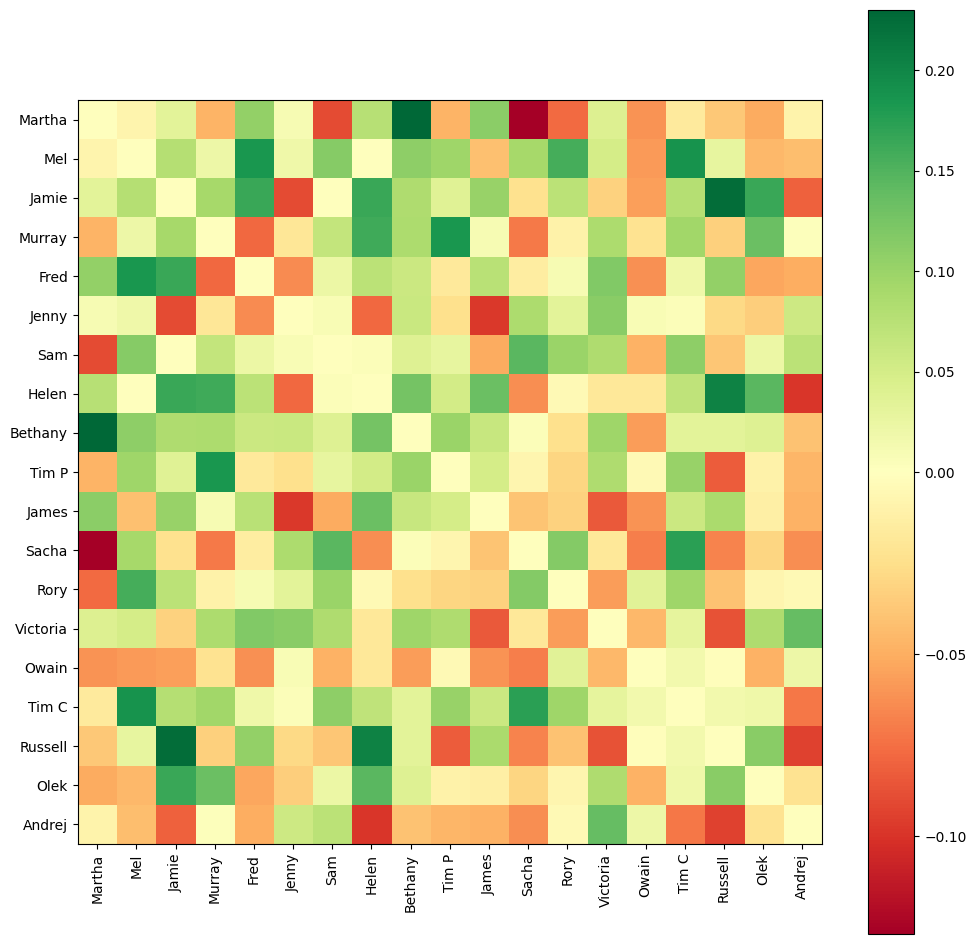

In [65]:
all_genres = list({genre for genres in df.genres for genre in genres})
from functools import reduce
from operator import add
x = df.groupby("submitter")["genres"].apply(lambda x: reduce(add, x)).reindex(winning_order).map(set)

matrix = np.zeros((len(winning_order), len(all_genres)))

for i, genres in enumerate(x.values):
    for j, genre in enumerate(all_genres):
        if genre in genres:
            matrix[i][j] = 1.0

correlation = np.corrcoef(matrix)
np.fill_diagonal(correlation, 0.0)

fig, ax = plt.subplots(figsize=(12,12))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
norm = TwoSlopeNorm(vmin=np.min(correlation),
                        vcenter=0,
                        vmax=np.max(correlation))

plt.imshow(correlation, cmap='RdYlGn', norm=norm, interpolation='nearest')
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')
plt.yticks(np.arange(len(winning_order)), winning_order)


cbar = plt.colorbar()

plt.show()




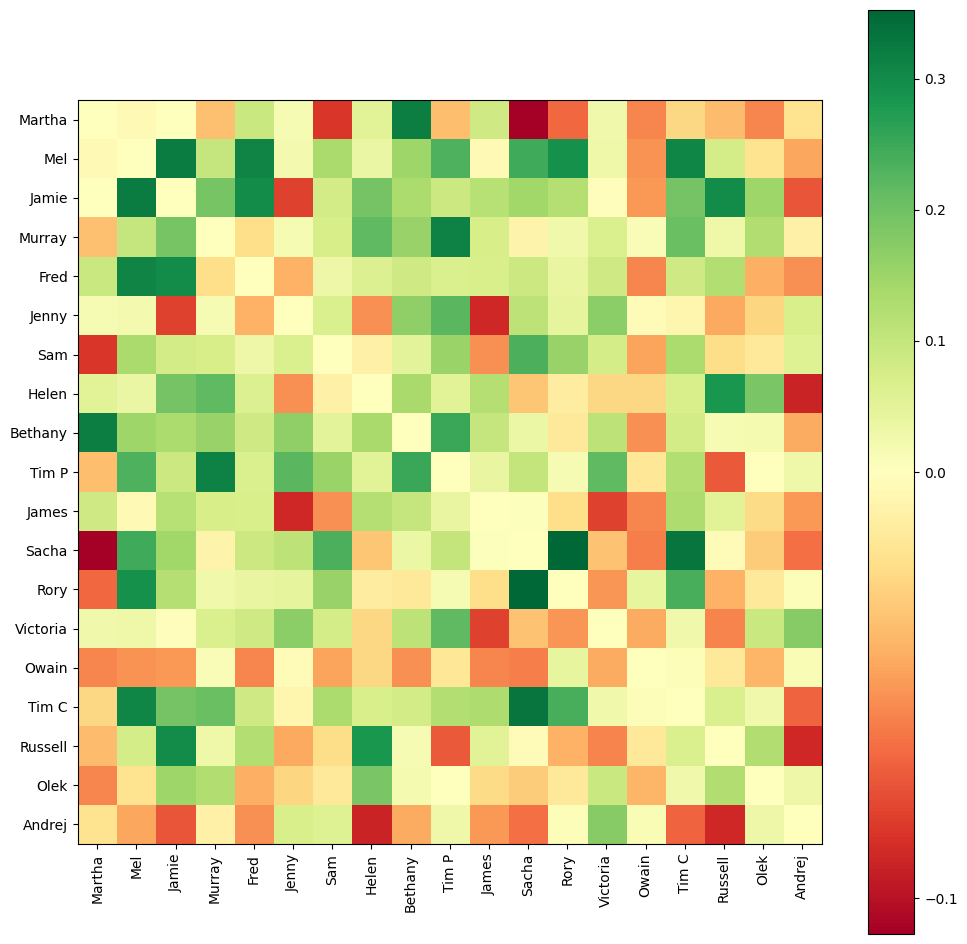

In [66]:
unique_genres = set()

for submitter in winning_order:
    rest = set(reduce(add, df[df.submitter != submitter]["genres"].values))
    unique = set(reduce(add, df[df.submitter == submitter]["genres"])).difference(rest)
    break

all_genres = list({genre for genres in df.genres for genre in genres})
from functools import reduce
from operator import add
x = df.groupby("submitter")["genres"].apply(lambda x: reduce(add, x)).reindex(winning_order).map(set)

matrix = np.zeros((len(winning_order), len(all_genres)))

for i, genres in enumerate(x.values):
    for j, genre in enumerate(all_genres):
        if genre in genres:
            matrix[i][j] = 1.0

correlation = np.corrcoef(matrix)
np.fill_diagonal(correlation, 0.0)

fig, ax = plt.subplots(figsize=(12,12))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
norm = TwoSlopeNorm(vmin=np.min(correlation),
                        vcenter=0,
                        vmax=np.max(correlation))

plt.imshow(correlation, cmap='RdYlGn', norm=norm, interpolation='nearest')
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')
plt.yticks(np.arange(len(winning_order)), winning_order)


cbar = plt.colorbar()

plt.show()

In [70]:
for submitter in winning_order:
    rest = df[df.submitter != submitter]["genres"]
    break
reduce(add, rest.values)

['ukrainian viral pop',
 'finnish pop',
 'uk pop',
 'moldovan pop',
 'classic russian pop',
 'ukrainian pop',
 'oulu metal',
 'trancecore',
 'hungarian metal',
 'hungarian rock',
 'magyar alternative',
 'nouvelle chanson francaise',
 'comic metal',
 'finnish hard rock',
 'finnish heavy metal',
 'lapland metal',
 'power metal',
 'greek pop',
 'laiko',
 'swedish pop',
 'norwegian pop',
 'sami',
 'uk diy punk',
 'dark rock',
 'neue deutsche harte',
 'swedish idol pop',
 'swedish pop',
 'adult standards',
 'rock-and-roll',
 'album rock',
 'classic rock',
 'permanent wave',
 'rock',
 'diva house',
 'dance pop',
 'girl group',
 'pop',
 'australian dance',
 'australian pop',
 'dance pop',
 'eurodance',
 'new wave pop',
 'hip house',
 'alternative rock',
 'britpop',
 'madchester',
 'permanent wave',
 'rock',
 'dance pop',
 'pop',
 'dance pop',
 'pop',
 'dance pop',
 'east coast hip hop',
 'hip hop',
 'hip pop',
 'pop rap',
 'r&b',
 'rap',
 'southern hip hop',
 'trap queen',
 'urban contemporar